In [33]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft

In [28]:
#验证测试代码
labeled_data = pd.read_csv("../tactileGestureDetection-main/DATA/Labeled_data/0724-7ST-Y1/labeled_data.csv")

# labeled_data.columns.tolist()
# label_0_data = labeled_data[labeled_data['label'] == 1]
# print(label_0_data.head())
# label_counts = labeled_data['label'].value_counts()
# print(label_counts)

In [49]:
#验证 数据块分类是否正确代码
labeled_data = pd.read_csv("/Users/shangyu/Documents/GitHub/contactInterpretation-main/tactileGestureDetection-main/DATA/tactile_dataset.csv")
# labeled_data
# labeled_data.columns.tolist()
# # label_0_data = labeled_data[labeled_data['label'] == 1]
# # print(label_0_data.head())

# 只筛选出 touch_type 为 'ST' 的数据
st_data = labeled_data[labeled_data['touch_type'] == 'DT']
# st_data
# 计算每个 (block_id, touch_type) 组合的出现次数
st_label_counts = st_data.groupby(['block_id', 'touch_type']).size()
st_label_counts
# 计算每个 (block_id, touch_type) 组合的出现次数
# label_counts = labeled_data.groupby(['block_id', 'touch_type']).size()
# label_counts


block_id  touch_type
0         DT            37
1         DT            31
2         DT            33
3         DT            33
4         DT            41
                        ..
299       DT            42
300       DT            52
301       DT            42
302       DT            38
303       DT            33
Length: 116, dtype: int64

In [63]:
#切割数据，每个打上对应的tactile type
import os
import pandas as pd

global_block_id = 0

def process_labeledDta(file_path, tactile_type):
    """处理单个labeled_data.csv文件，将连续label为1的数据块标记为指定触碰类型"""
    global global_block_id
    df = pd.read_csv(file_path)
    labeled_blocks = []

    in_block = False
    block_start = 0
    block_info = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc('label')] == 1 and not in_block:
            in_block = True
            block_start = i
        elif df.iloc[i, df.columns.get_loc('label')] == 0 and in_block:
            in_block = False
            block = df.iloc[block_start:i].copy()
            block['touch_type'] = tactile_type
            block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
            labeled_blocks.append(block)
            block_info.append((global_block_id, block_start, i - 1))  # 记录块的ID、开始行和结束行
            global_block_id += 1  # 增加全局唯一数据块标识符

    if in_block:
        block = df.iloc[block_start:].copy()
        block['touch_type'] = tactile_type
        block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
        labeled_blocks.append(block)
        block_info.append((global_block_id, block_start, len(df) - 1))  # 记录块的ID、开始行和结束行
        global_block_id += 1  # 增加全局唯一数据块标识符
    
    return labeled_blocks, block_info

def calculate_zero_counts(df, block_info):
    """计算相邻数据块之间0的个数"""
    zero_counts = []
    for i in range(len(block_info) - 1):
        end_of_current_block = block_info[i][2]
        start_of_next_block = block_info[i + 1][1]
        zero_count = (df.iloc[end_of_current_block + 1:start_of_next_block]['label'] == 0).sum()
        zero_counts.append((block_info[i][0], block_info[i + 1][0], zero_count))
    return zero_counts

def determine_double_taps(zero_counts):
    """根据0的个数决定哪些单拍应该合并为双拍"""
    zero_counts_values = [count[2] for count in zero_counts]
    zero_counts_values.sort()
    n = len(zero_counts_values)
    max_value_index = int((n / 2) / (n + 1) * n)
    max_value = zero_counts_values[max_value_index]
    min_value = zero_counts_values[0]
    
    double_tap_blocks = []
    for start_block_id, end_block_id, zero_count in zero_counts:
        if min_value <= zero_count <= max_value:
            double_tap_blocks.append((start_block_id, end_block_id))
    return double_tap_blocks

def merge_continuous_double_taps(double_tap_blocks):
    """合并连续的双拍块对"""
    merged_double_tap_blocks = []
    current_start = None
    current_end = None
    
    for start_block_id, end_block_id in double_tap_blocks:
        if current_start is None:
            current_start = start_block_id
            current_end = end_block_id
        elif start_block_id == current_end:
            current_end = end_block_id
        else:
            merged_double_tap_blocks.append((current_start, current_end))
            current_start = start_block_id
            current_end = end_block_id
    
    if current_start is not None:
        merged_double_tap_blocks.append((current_start, current_end))
    
    return merged_double_tap_blocks

def merge_double_taps(df, block_info, double_tap_blocks):
    """合并确定的双拍数据块"""
    merged_double_tap_blocks = merge_continuous_double_taps(double_tap_blocks)
    merged_blocks = []
    new_block_id = block_info[0][0]  # 从第一个 block_id 开始连续编号

    merge_info_list = []  # 存储合并信息的列表
    
    for start_block_id, end_block_id in merged_double_tap_blocks:
        start_row = next(bi[1] for bi in block_info if bi[0] == start_block_id)
        end_row = next(bi[2] for bi in block_info if bi[0] == end_block_id)
        
        merged_block = df.iloc[start_row:end_row + 1].copy()
        merged_block['block_id'] = new_block_id  # 使用新的连续编号
        merged_block['touch_type'] = 'DT'  # 标记为双拍

        merge_info_list.append((start_block_id, end_block_id, new_block_id))  # 添加合并信息到列表
        
        merged_blocks.append(merged_block)
        new_block_id += 1
    

    print(f"双击实际合并信息列表: {merge_info_list}")
    return merged_blocks

def process_double_tap_folder(df, tactile_type):
    """处理双拍数据，将挨得非常近的两个连续块标记为双拍类型"""
    
    blocks, block_info = process_labeledDta(file_path, tactile_type)
    print(f"开始处理{file_path}")
    print(f"block_info is {block_info}")

    zero_counts = calculate_zero_counts(df, block_info)
    print(f"zero_counts is {zero_counts}")
    double_tap_blocks = determine_double_taps(zero_counts)
    print(f"double_tap_blocks is {double_tap_blocks}")
    merged_blocks = merge_double_taps(df, block_info, double_tap_blocks)
    # print(f"merged_blocks is {merged_blocks}")

    # 打印数据块的个数
    block_count = len(merged_blocks)
    print(f"文件夹 {folder_name} 中的数据块个数为: {block_count}")
    return merged_blocks

def process_single_folder(data_folder, folder_name):
    """处理指定文件夹下的labeled_data.csv，统计数据块个数，并打印块的开始行和结束行"""
    folder_path = os.path.join(data_folder, folder_name)
    
    if os.path.isdir(folder_path):  # Check if it's a directory
        file_path = os.path.join(folder_path, 'labeled_data.csv')
        
        if os.path.isfile(file_path):
            tactile_type = folder_name.split('-')[1][1:]
            df = pd.read_csv(file_path)
            
            if tactile_type == 'DT':
                blocks = process_double_tap_folder(df, tactile_type)
            elif tactile_type in ['ST', 'G', 'P']:
                blocks, _ = process_labeledDta(file_path, tactile_type)
            else:
                blocks = []
            
            return blocks
        else:
            print(f"文件夹 {folder_name} 下没有找到labeled_data.csv文件")
            return []
    else:
        print(f"{folder_name} 不是有效的文件夹")
        return []

def process_all_folders(data_folder, output_file):
    """处理所有子文件夹，合并所有数据块，生成tactile_dataset.csv文件"""
    all_blocks = []
    for folder_name in os.listdir(data_folder):
        folder_blocks = process_single_folder(data_folder, folder_name)
        all_blocks.extend(folder_blocks)
    
    if all_blocks:
        result_df = pd.concat(all_blocks, ignore_index=True)
        output_path = os.path.join(output_file, 'tactile_dataset.csv')
        print(output_path )
        
        # 删除已存在的文件
        if os.path.exists(output_path):
            os.remove(output_path)
        
        # 保存新文件
        result_df.to_csv(output_path, index=False)
        print(f"tactile_dataset.csv 文件已生成，包含 {len(all_blocks)} 个数据块")

    else:
        print("没有数据块被处理")

# 设置数据文件夹路径
data_folder = '../tactileGestureDetection-main/DATA/Labeled_data'
output_file = '../tactileGestureDetection-main/DATA/'
process_all_folders(data_folder, output_file)



开始处理/Users/shangyu/Documents/GitHub/contactInterpretation-main/tactileGestureDetection-main/DATA/Labeled_data/0724-7DT-S1/labeled_data.csv
block_info is [(0, 401, 409), (1, 427, 437), (2, 754, 762), (3, 775, 784), (4, 1180, 1191), (5, 1201, 1212), (6, 2295, 2304), (7, 2318, 2327), (8, 2629, 2639), (9, 2655, 2669), (10, 2939, 2951), (11, 2965, 2976), (12, 3316, 3325), (13, 3343, 3354), (14, 3767, 3775), (15, 3793, 3793), (16, 4179, 4190), (17, 4203, 4218), (18, 4572, 4583), (19, 4597, 4602), (20, 4947, 4948), (21, 4954, 4955), (22, 4973, 4986), (23, 5313, 5326), (24, 5341, 5353), (25, 5675, 5688), (26, 5704, 5716), (27, 6125, 6133), (28, 6150, 6151), (29, 6524, 6535), (30, 6549, 6563), (31, 6867, 6876), (32, 6894, 6898), (33, 7213, 7223), (34, 7238, 7252), (35, 7542, 7550), (36, 7567, 7574), (37, 7891, 7895), (38, 7915, 7923), (39, 8213, 8222), (40, 8239, 8252), (41, 8638, 8650), (42, 8663, 8679), (43, 8981, 8987), (44, 9003, 9013), (45, 9345, 9347), (46, 9370, 9378), (47, 9671, 9683), 

In [56]:
#(ST,G,P)单个数据集的切分代码
import os
import pandas as pd

global_block_id = 0

def process_labeledDta(file_path, tactile_type):
    """处理单个labeled_data.csv文件，将连续label为1的数据块标记为指定触碰类型"""
    global global_block_id
    df = pd.read_csv(file_path)
    # print(f"现在读的数据来自 {file_path}")
    labeled_blocks = []

    in_block = False
    block_start = 0
    block_info = []
    zero_counts = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc('label')] == 1 and not in_block:
            in_block = True
            block_start = i
        elif df.iloc[i, df.columns.get_loc('label')] == 0 and in_block:
            in_block = False
            block = df.iloc[block_start:i].copy()
            block['touch_type'] = tactile_type
            block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
            labeled_blocks.append(block)
            block_info.append((global_block_id, block_start, i - 1))  # 记录块的ID、开始行和结束行
            global_block_id += 1  # 增加全局唯一数据块标识符

    if in_block:
        block = df.iloc[block_start:].copy()
        block['touch_type'] = tactile_type
        block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
        labeled_blocks.append(block)
        block_info.append((global_block_id, block_start, len(df) - 1))  # 记录块的ID、开始行和结束行
        global_block_id += 1  # 增加全局唯一数据块标识符

        # 计算偶数数据块和相邻奇数数据块之间0的个数
    for i in range(0, len(block_info) - 1, 2):
        end_of_even_block = block_info[i][2]
        start_of_odd_block = block_info[i + 1][1]
        zero_count = (df.iloc[end_of_even_block + 1:start_of_odd_block]['label'] == 0).sum()
        zero_counts.append((block_info[i][0], block_info[i + 1][0], zero_count))
    
    return labeled_blocks, block_info, zero_counts

def process_single_folder(data_folder, folder_name):
    """处理指定文件夹下的labeled_data.csv，统计数据块个数，并打印块的开始行和结束行"""
    folder_path = os.path.join(data_folder, folder_name)
    
    if os.path.isdir(folder_path):  # Check if it's a directory
        file_path = os.path.join(folder_path, 'labeled_data.csv')
        
        if os.path.isfile(file_path):
            tactile_type = folder_name.split('-')[1][1:]
            
            if tactile_type in ['ST','G','P']:
                blocks, block_info,zero_counts = process_labeledDta(file_path, tactile_type)
                
                # 打印数据块的个数
                block_count = len(blocks)
                print(f"文件夹 {folder_name} 中的数据块个数为: {block_count}")
                
                # 打印数据块的开始行和结束行
                # for block_id, start_row, end_row in block_info:
                    # print(f"数据块 {block_id} 从行 {start_row} 到行 {end_row}")

                # 打印偶数数据块和相邻奇数数据块之间0的个数
                for even_block_id, odd_block_id, zero_count in zero_counts:
                    print(f"数据块 {even_block_id} 和数据块 {odd_block_id} 之间有 {zero_count} 个0")
        else:
            print(f"文件夹 {folder_name} 下没有找到labeled_data.csv文件")
    else:
        print(f"{folder_name} 不是有效的文件夹")

# 指定文件夹
data_folder = '../tactileGestureDetection-main/DATA/Labeled_data'
folder_name = '0724-7G-S1'  # 替换为要处理的文件夹名称
process_single_folder(data_folder, folder_name)

文件夹 0724-7G-S1 中的数据块个数为: 66
数据块 0 和数据块 1 之间有 208 个0
数据块 2 和数据块 3 之间有 176 个0
数据块 4 和数据块 5 之间有 154 个0
数据块 6 和数据块 7 之间有 80 个0
数据块 8 和数据块 9 之间有 125 个0
数据块 10 和数据块 11 之间有 97 个0
数据块 12 和数据块 13 之间有 135 个0
数据块 14 和数据块 15 之间有 97 个0
数据块 16 和数据块 17 之间有 112 个0
数据块 18 和数据块 19 之间有 111 个0
数据块 20 和数据块 21 之间有 139 个0
数据块 22 和数据块 23 之间有 72 个0
数据块 24 和数据块 25 之间有 137 个0
数据块 26 和数据块 27 之间有 165 个0
数据块 28 和数据块 29 之间有 211 个0
数据块 30 和数据块 31 之间有 142 个0
数据块 32 和数据块 33 之间有 164 个0
数据块 34 和数据块 35 之间有 105 个0
数据块 36 和数据块 37 之间有 108 个0
数据块 38 和数据块 39 之间有 88 个0
数据块 40 和数据块 41 之间有 11 个0
数据块 42 和数据块 43 之间有 91 个0
数据块 44 和数据块 45 之间有 115 个0
数据块 46 和数据块 47 之间有 97 个0
数据块 48 和数据块 49 之间有 12 个0
数据块 50 和数据块 51 之间有 114 个0
数据块 52 和数据块 53 之间有 164 个0
数据块 54 和数据块 55 之间有 132 个0
数据块 56 和数据块 57 之间有 69 个0
数据块 58 和数据块 59 之间有 94 个0
数据块 60 和数据块 61 之间有 150 个0
数据块 62 和数据块 63 之间有 120 个0
数据块 64 和数据块 65 之间有 203 个0


In [1]:
# 双拍数据分割测试代码
import os
import pandas as pd
import numpy as np

global_block_id = 0

def process_labeledDta(file_path, tactile_type):
    """处理单个labeled_data.csv文件，将连续label为1的数据块标记为指定触碰类型"""
    global global_block_id
    df = pd.read_csv(file_path)
    labeled_blocks = []

    in_block = False
    block_start = 0
    block_info = []

    for i in range(len(df)):
        if df.iloc[i, df.columns.get_loc('label')] == 1 and not in_block:
            in_block = True
            block_start = i
        elif df.iloc[i, df.columns.get_loc('label')] == 0 and in_block:
            in_block = False
            block = df.iloc[block_start:i].copy()
            block['touch_type'] = tactile_type
            block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
            labeled_blocks.append(block)
            block_info.append((global_block_id, block_start, i - 1))  # 记录块的ID、开始行和结束行
            global_block_id += 1  # 增加全局唯一数据块标识符

    if in_block:
        block = df.iloc[block_start:].copy()
        block['touch_type'] = tactile_type
        block['block_id'] = global_block_id  # 添加全局唯一数据块标识符
        labeled_blocks.append(block)
        block_info.append((global_block_id, block_start, len(df) - 1))  # 记录块的ID、开始行和结束行
        global_block_id += 1  # 增加全局唯一数据块标识符
    
    return labeled_blocks, block_info

def calculate_zero_counts(df, block_info):
    """计算相邻数据块之间0的个数"""
    zero_counts = []
    for i in range(len(block_info) - 1):
        end_of_current_block = block_info[i][2]
        start_of_next_block = block_info[i + 1][1]
        zero_count = (df.iloc[end_of_current_block + 1:start_of_next_block]['label'] == 0).sum()
        zero_counts.append((block_info[i][0], block_info[i + 1][0], zero_count))
    return zero_counts

def determine_double_taps(zero_counts):
    """根据0的个数决定哪些单拍应该合并为双拍"""
    zero_counts_values = [count[2] for count in zero_counts]
    zero_counts_values.sort()
    print(f"排序后的 0值排序是 {zero_counts_values}")
    n = len(zero_counts_values)
    print(f"n 值是 {n}")
    max_value_index = int((n / 2) / (n + 1) * n)
    print(f"max_index is {max_value_index}")
    max_value = zero_counts_values[max_value_index]
    print(f"最大值是：{max_value}")
    min_value = zero_counts_values[0]
    print(f"最小值是：{min_value}")
    
    double_tap_blocks = []
    for start_block_id, end_block_id, zero_count in zero_counts:
        if min_value <= zero_count <= max_value:
            double_tap_blocks.append((start_block_id, end_block_id))
    return double_tap_blocks

def merge_continuous_double_taps(double_tap_blocks):
    """合并连续的双拍块对"""
    merged_double_tap_blocks = []
    current_start = None
    current_end = None
    
    for start_block_id, end_block_id in double_tap_blocks:
        if current_start is None:
            current_start = start_block_id
            current_end = end_block_id
        elif start_block_id == current_end:
            current_end = end_block_id
        else:
            merged_double_tap_blocks.append((current_start, current_end))
            current_start = start_block_id
            current_end = end_block_id
    
    if current_start is not None:
        merged_double_tap_blocks.append((current_start, current_end))
    
    return merged_double_tap_blocks

def merge_double_taps(df, block_info, double_tap_blocks):
    """合并确定的双拍数据块"""
    merged_double_tap_blocks = merge_continuous_double_taps(double_tap_blocks)
    merged_blocks = []
    new_block_id = block_info[0][0]  # 从第一个 block_id 开始连续编号
    
    for start_block_id, end_block_id in merged_double_tap_blocks:
        start_row = block_info[start_block_id][1]
        end_row = block_info[end_block_id][2]
        
        merged_block = df.iloc[start_row:end_row + 1].copy()
        merged_block['block_id'] = new_block_id  # 使用新的连续编号
        merged_block['touch_type'] = 'DT'  # 标记为双拍
        
        merged_blocks.append(merged_block)
        new_block_id += 1
    
    return merged_blocks

def process_double_tap_folder(data_folder, folder_name):
    """处理双拍数据，将挨得非常近的两个连续块标记为双拍类型"""
    folder_path = os.path.join(data_folder, folder_name)
    
    if os.path.isdir(folder_path):  # Check if it's a directory
        file_path = os.path.join(folder_path, 'labeled_data.csv')
        
        if os.path.isfile(file_path):
            tactile_type = folder_name.split('-')[1][1:]
            df = pd.read_csv(file_path)
            blocks, block_info = process_labeledDta(file_path, tactile_type)
            print(f"block_info 是 {block_info}")
            zero_counts = calculate_zero_counts(df, block_info)
            print(f"所有数据块之间0的个数是 {zero_counts}")

            double_tap_blocks = determine_double_taps(zero_counts)
            print(f"属于一组的 block 是 {double_tap_blocks}")
            merged_blocks = merge_double_taps(df, block_info, double_tap_blocks)
            
            # 打印数据块的个数
            block_count = len(merged_blocks)
            print(f"文件夹 {folder_name} 中的数据块个数为: {block_count}")
            
            # 打印合并后的数据块的开始行和结束行
            for block in merged_blocks:
                start_row = block.index[0]
                end_row = block.index[-1]
                block_id = block['block_id'].values[0]
                print(f"数据块 {block_id} 从行 {start_row} 到行 {end_row}")
            
        else:
            print(f"文件夹 {folder_name} 下没有找到labeled_data.csv文件")
    else:
        print(f"{folder_name} 不是有效的文件夹")


# 指定文件夹
data_folder = '../tactileGestureDetection-main/DATA/Labeled_data'
folder_name = '0724-7DT-S1'  # 替换为要处理的文件夹名称
process_double_tap_folder(data_folder, folder_name)


block_info 是 [(0, 401, 409), (1, 427, 437), (2, 754, 762), (3, 775, 784), (4, 1180, 1191), (5, 1201, 1212), (6, 2295, 2304), (7, 2318, 2327), (8, 2629, 2639), (9, 2655, 2669), (10, 2939, 2951), (11, 2965, 2976), (12, 3316, 3325), (13, 3343, 3354), (14, 3767, 3775), (15, 3793, 3793), (16, 4179, 4190), (17, 4203, 4218), (18, 4572, 4583), (19, 4597, 4602), (20, 4947, 4948), (21, 4954, 4955), (22, 4973, 4986), (23, 5313, 5326), (24, 5341, 5353), (25, 5675, 5688), (26, 5704, 5716), (27, 6125, 6133), (28, 6150, 6151), (29, 6524, 6535), (30, 6549, 6563), (31, 6867, 6876), (32, 6894, 6898), (33, 7213, 7223), (34, 7238, 7252), (35, 7542, 7550), (36, 7567, 7574), (37, 7891, 7895), (38, 7915, 7923), (39, 8213, 8222), (40, 8239, 8252), (41, 8638, 8650), (42, 8663, 8679), (43, 8981, 8987), (44, 9003, 9013), (45, 9345, 9347), (46, 9370, 9378), (47, 9671, 9683), (48, 9697, 9700), (49, 9996, 10004), (50, 10025, 10039), (51, 10371, 10380), (52, 10397, 10407), (53, 10762, 10763), (54, 10789, 10798), (55

In [30]:
# 测试验证代码
import pandas as pd

# 读取CSV文件
file_path = '/Users/shangyu/Documents/GitHub/contactInterpretation-main/tactileGestureDetection-main/DATA/Labeled_data/0724-7DT-S1/labeled_data.csv'
df = pd.read_csv(file_path)

# 指定要显示的行范围
start_row = 408 # 起始行（包含）
end_row = 438  # 结束行（包含）

# 显示从start_row到end_row的行
# print(df.iloc[start_row:end_row + 1])

In [83]:
# time-frequency analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

file_path = '/Users/shangyu/Documents/GitHub/contactInterpretation-main/tactileGestureDetection-main/DATA/tactile_dataset.csv'
data = pd.read_csv(file_path)

output_dir = '/Users/shangyu/Documents/GitHub/contactInterpretation-main/tactileGestureDetection-main/DATA/STFT_images/'

# 创建保存图像的目录
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

data = pd.read_csv(file_path)

# 排除不感兴趣的列
columns_of_interest = [col for col in data.columns if col not in ['index', 'time', 'label', 'touch_type', 'block_id']]

# 提取采样率
time_data = data['time'].values
fs = 1 / np.mean(np.diff(time_data))  # 计算采样率

# 创建一个列表，用于记录图像文件名和对应的block_id和touch_type
image_records = []

# 分块绘制
block_ids = data['block_id'].unique()

for block_id in block_ids:
    block_data = data[data['block_id'] == block_id]
    touch_type = block_data['touch_type'].iloc[0]
    
    # 创建一个图形
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f'Block ID: {block_id}, Touch_type: {touch_type}')
    
    for col in columns_of_interest:
        signal = block_data[col].values
        
        # 计算STFT
        nperseg = min(256, len(signal))  # 确保窗口长度不超过信号长度
        noverlap = nperseg // 2
        f, t, Zxx = stft(signal, fs, nperseg=nperseg, noverlap=noverlap)
        
        # 绘制时频谱图
        cax = ax.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', alpha=0.7)
    
    # 添加图例和标签
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    fig.colorbar(cax, ax=ax, label='Magnitude')
    
    # 保存图像
    image_filename = f'block_{block_id}_touch_{touch_type}.png'
    image_path = os.path.join(output_dir, image_filename)
    plt.savefig(image_path)
    plt.close(fig)
    
    # 记录图像文件名和对应的block_id和touch_type
    image_records.append({'image_filename': image_filename, 'block_id': block_id, 'touch_type': touch_type})

# 保存记录为CSV文件
records_df = pd.DataFrame(image_records)
records_df.to_csv(os.path.join(output_dir, 'image_records.csv'), index=False)

print("STFT图像和记录已成功保存。")

STFT图像和记录已成功保存。


Epoch 1/30
9/9 [==============================] - 48s 5s/step - loss: 15.5592 - accuracy: 0.4781 - val_loss: 1.2126 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - 50s 6s/step - loss: 5.0962 - accuracy: 0.6679 - val_loss: 1.0985 - val_accuracy: 0.7966 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - 49s 6s/step - loss: 4.3647 - accuracy: 0.6642 - val_loss: 1.2379 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - 50s 6s/step - loss: 2.3698 - accuracy: 0.7226 - val_loss: 1.4775 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 5/30
9/9 [==============================] - 51s 6s/step - loss: 1.9391 - accuracy: 0.7336 - val_loss: 1.0097 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 6/30
9/9 [==============================] - 51s 6s/step - loss: 1.6535 - accuracy: 0.7044 - val_loss: 0.5658 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 7/30
9/9 [==============================] - 50s 6s/step - loss: 1.0755 - accuracy: 0.75

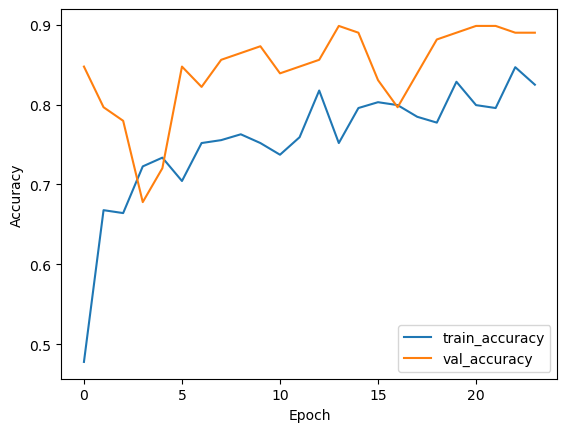

In [3]:
# Built and train CNN model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# 读取数据和图像
data_path = "/Users/shangyu/Documents/GitHub/contactInterpretation-main/tactileGestureDetection-main/DATA/STFT_images/"
file = data_path + 'image_records.csv'
image_df = pd.read_csv(file)

images = []
labels = []

for index, row in image_df.iterrows():
    img_path = os.path.join(data_path, row['image_filename'])
    img = Image.open(img_path).convert('RGB')
    img = img.resize((128, 128))
    img = np.array(img)
    images.append(img)
    labels.append(row['touch_type'])

images = np.array(images)
labels = np.array(labels)

# 标签编码
label_classes = np.unique(labels)
label_map = {label: idx for idx, label in enumerate(label_classes)}
labels = np.array([label_map[label] for label in labels])
labels = to_categorical(labels, num_classes=len(label_classes))

# 数据分割
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# 数据增强
train_data = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True
)
val_data = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_data.flow(X_train, y_train, batch_size=32)
val_generator = val_data.flow(X_val, y_val, batch_size=32)

# 使用预训练的VGG16模型
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # 冻结预训练模型的卷积层

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_classes), activation='softmax')
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 定义回调函数
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
fitted = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[reduce_lr, early_stopping])

# 可视化训练过程
plt.plot(fitted.history['accuracy'], label='train_accuracy')
plt.plot(fitted.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
